Now we recreate the results after oversampling by translations

In [1]:
#import ast
import copy
#import csv
#import glob
#import json
import random
import transformers
from datetime import datetime

import deepl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from torch import nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
from transformers import (AutoConfig, AutoModelForSequenceClassification,
                          AutoTokenizer, BertForSequenceClassification,
                          BertModel, Trainer, TrainingArguments)

from transformers.modeling_outputs import SequenceClassifierOutput
from transformers.models.bert.modeling_bert import *
from transformers.utils.dummy_tf_objects import TFDPRQuestionEncoder

In [2]:
ROOT_PATH = os.getcwd()
DATA_PATH = '/data'
MODEL_PATH = '/model'
RESULTS_PATH = '/results'

In [3]:
# If this parameter is set on true, oversampling will be performed on the dataframe
oversample_dataframe = True

# For the use of the Deepl API (is used to oversample the data set), a Deepl Authentication Key is needed
# To obtain such a key, a free trial can be started on the following page: https://www.deepl.com/docs-api/
# When 500.000 characters have been translated, a credit card is needed to start a real abonnement and to access the API
deepl_auth_key = 'ec362cc6-2825-caaf-5273-8600eb06895e:fx'

# This parameter specifies the number of iterations after which the intermediate result of the dataframe should be stored repeatedly
backup_oversampled_dataframe_after_rows = 40

def set_default_staerkegrad_df(df):
  """ 
  set_default_staerkegrad accepts a dataframe as input. Checks if there is a column named "Staerkegrad"
  and if there is inserts into empty fields in that column the mostly used value from the column.

  :param df: a pandas dataframe
  :return: a pandas dataframe, where for every undefined entry in the column "Staerkgegrad" the most common value from all rows is set. If there is no such column in the input dataframe, the input dataframe is returned.  
  """
  if ('Stärkegrad (A, B, C)' not in df.columns):
    print('[set_default_staerkegrad_df]: Given dataframe does not consist of a column "Staerkegrad"!')
    return df
  else:
    most_used_staerkegrad = df['Stärkegrad (A, B, C)'].value_counts().index[0]
    df.fillna(value={'Stärkegrad (A, B, C)': most_used_staerkegrad})
    return df

def translate(text, target_language):
  """
  translate translates the input text into the target language.

  :param text: the text to be translated
  :param target_language: the deepl target language expression, examples are 'DE' or 'EN-US'
  :return: a string, the translation of :param text into the :param target_language
  """
  translator = deepl.Translator(deepl_auth_key) 
  result = translator.translate_text(text, target_lang=target_language) 
  translated_text = result.text
  return translated_text

def translate_into_english_and_back(text):
  """
  translate_into_english_and_back translates the input text into english and then into German.

  :param text: the text to be translated
  :return: a string. Returned is the result from translating :param text into englisch and after that into German.
  """
  translator = deepl.Translator(deepl_auth_key) 
  result_eng = translator.translate_text(text, target_lang='EN-US')
  result_ger = translator.translate_text(result_eng.text, target_lang='DE')
  return result_ger.text

def translate_into_target_language_and_back(text, target_language):
  """
  translate_into_target_language_and_back translates the input text into the given target_language and then into German.

  :param text: the text to be translated
  :param target_language: the language
  :return: a string. Returned is the result from translating :param text into :param target_language and then into German. 
  """
  translator = deepl.Translator(deepl_auth_key) 
  result_eng = translator.translate_text(text, target_lang=target_language)
  result_ger = translator.translate_text(result_eng.text, target_lang='DE')
  return result_ger.text

def oversample_dataframe(df):
  """
  Accepts a dataframe and returns the dataframe with oversampled data. The function was written for the known dataset of the Goldstandard. 
  In detail, every Textstelle (from metaphors only) from the input dataframe is taken, translated into four languages (english, spanish, czech and polish) and back into German.
  By this way, for each Textstelle from :param df, four new texts are generated and added to the output dataframe. 

  :param df: a pandas dataframe. 
  :return: a pandas dataframe. In the output dataframe, four columns have been added, in which the different back and forth translated German texts are. 
  """
  # Before the oversampling, the counts of unique rows in the input df and of rows which are metaphors are printed
  print('Ausprägungen und Anzahl Werte für gold_standard_df vor Oversampling:', df['Metapher?'].value_counts())
  print('Metaphern im gold_standard_df vor Oversampling', df['Metapher?'].value_counts().Metapher)

  # To backup interim results, this counter is initialized
  count = 1

  # To keep count of successfully added translated metaphor texts, the following counter is initialized
  count_successfully_added_metaphor_texts = 0

  # Split the input dataframe into two dataframes, one containing only metaphors and one with only not metaphors
  only_metaphor_df = df[(df['Metapher?'] == 'Metapher')]
  no_metaphors_df = df[(df['Metapher?'] != 'Metapher')]

  # To the dataframe containing only metaphors, add four columns where the newly generated texts can be inserted to
  only_metaphor_df['Synonym (aus Englischem)'] = ""
  only_metaphor_df['Synonym (aus Spanischem)'] = ""
  only_metaphor_df['Synonym (aus Tchechischem)'] = ""
  only_metaphor_df['Synonym (aus Polnischem)'] = ""
  
  # Loop over all rows in the dataframe containing only metaphors and translate the text back and forth and insert the German result in the correct dataframe cell
  for index, row in only_metaphor_df.iterrows():
    text = row['Textstelle']
    row['Synonym (aus Englischem)'] = translate_into_target_language_and_back(text, 'EN-US')
    row['Synonym (aus Spanischem)'] = translate_into_target_language_and_back(text, 'ES')
    row['Synonym (aus Tchechischem)'] = translate_into_target_language_and_back(text, 'CS')
    row['Synonym (aus Polnischem)'] = translate_into_target_language_and_back(text, 'PL')
    count_successfully_added_metaphor_texts += 4
    print('working, count:', count)

    # Backup interim results of the dataframe as csv files every 'backup_oversampled_dataframe_after_rows' iterations
    if (count % backup_oversampled_dataframe_after_rows == 0): 
      only_metaphor_df.to_csv('only_metaphor_df_four_languages_backup_iteration_' + str(count) + '.csv', index=False)

    # Increase counter
    count+=1

  # After the for loop, the two dataframes only metaphor and not metaphors need to get concatenated again
  oversampled_data_df = only_metaphor_df.append(no_metaphors_df)

  # After the oversampling, print the counts of unique rows in the oversampled dataframe and of rows which are metaphors again to get an overview on the results of the data augmentation 
  print('Ausprägungen und Anzahl Werte für gold_standard_df nach Oversampling:', oversampled_data_df['Metapher?'].value_counts())
  print('Metaphern im gold_standard_df nach Oversampling', oversampled_data_df['Metapher?'].value_counts().Metapher + count_successfully_added_metaphor_texts)

  return oversampled_data_df

In [4]:
def save_settings(path, annotators, epochs, folds, model_type, oversampling, smote, comment):
  """
  Saves the given settings to a text file at a given path
  :param path: the path to output the text file to
  :param annotators: The annotators to save 
  :param epochs: The number of epochs to save 
  :param folds: The number of folds to save 
  :param model_type: The model type to save 
  :param oversampling: The boolean if oversampling is activated 
  :param smote: The K for SMOTE to save 
  :param comment: A free comment to save in the text file
  """  
  
  lines = []
  lines.append('Annotators: ' + ', '.join(annotators))
  lines.append('Epochs: ' + str(epochs))
  lines.append('Folds: ' + str(folds))
  lines.append('Model Type: ' + model_type)
  lines.append('Oversampling: ' + ("On" if oversampling else "Off"))
  lines.append('SMOTE: ' + (("On (K="+str(smote)+")") if smote>0 else "Off"))
  lines.append('Comment: ' + comment)

  with open(path+'/settings.txt', 'w') as f: 
    f.write('\n'.join(lines))

  print("Settings saved to", path)

In [5]:
# Loading annotated data for individual annotators
raw_df = pd.read_csv(ROOT_PATH + DATA_PATH + '/Annotationen-Stufe-2.txt', index_col=0)
# Drop rows where Textstelle is NaN
index_names = raw_df[raw_df['Textstelle'].isnull()].index
raw_df.drop(index_names, inplace=True)
# setting the Stärkegrad if not present
raw_df = set_default_staerkegrad_df(raw_df)

In [6]:
# Loading annotated data of the gold standard
gold_standard_df = pd.read_csv(ROOT_PATH + DATA_PATH + '/Annotationen-Stufe-2-GoldStandard.csv')

# Loading annotated data for non-metaphors
no_metaphor_df = pd.read_csv(ROOT_PATH + DATA_PATH + '/NoMetaphor.csv', index_col=0)

# Combine all data into one DataFrame
raw_df = pd.concat([raw_df, gold_standard_df, no_metaphor_df], axis=0,ignore_index=True)

# If the related parameter is set to true and a valid Deepl API Key is present, oversampling will be performed on the raw_df and this oversampled_data_df will be saved as .csv file
if (oversample_dataframe and deepl_auth_key != 'DEEPL_AUTH_KEY'):
  oversampled_data_df = oversample_dataframe(gold_standard_df)
  oversampled_data_df.to_csv('goldstandard_dataframe_oversampled.csv', index=False)

display(raw_df[raw_df['Metapher?'] == 'Metapher'])

Ausprägungen und Anzahl Werte für gold_standard_df vor Oversampling: Metaphernkandidat    529
Metapher             129
Name: Metapher?, dtype: int64
Metaphern im gold_standard_df vor Oversampling 129


/var/folders/j4/qmf6qmvd1gv0nctgx3m6jm3r0000gn/T/ipykernel_26536/3817409328.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_metaphor_df['Synonym (aus Englischem)'] = ""
/var/folders/j4/qmf6qmvd1gv0nctgx3m6jm3r0000gn/T/ipykernel_26536/3817409328.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_metaphor_df['Synonym (aus Spanischem)'] = ""
/var/folders/j4/qmf6qmvd1gv0nctgx3m6jm3r0000gn/T/ipykernel_26536/3817409328.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

working, count: 1
working, count: 2
working, count: 3
working, count: 4
working, count: 5
working, count: 6
working, count: 7
working, count: 8
working, count: 9
working, count: 10
working, count: 11
working, count: 12
working, count: 13
working, count: 14
working, count: 15
working, count: 16
working, count: 17
working, count: 18
working, count: 19
working, count: 20
working, count: 21
working, count: 22
working, count: 23
working, count: 24
working, count: 25
working, count: 26
working, count: 27
working, count: 28
working, count: 29
working, count: 30
working, count: 31
working, count: 32
working, count: 33
working, count: 34
working, count: 35
working, count: 36
working, count: 37
working, count: 38
working, count: 39
working, count: 40
working, count: 41
working, count: 42
working, count: 43
working, count: 44
working, count: 45
working, count: 46
working, count: 47
working, count: 48
working, count: 49
working, count: 50
working, count: 51
working, count: 52
working, count: 53
wo

/var/folders/j4/qmf6qmvd1gv0nctgx3m6jm3r0000gn/T/ipykernel_26536/3817409328.py:113: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  oversampled_data_df = only_metaphor_df.append(no_metaphors_df)


,Seite,Textstelle,Metapher?,Fokus,Rahmen,"Stärkegrad (A, B, C)",Begründung/Kommentar,Annotator,Unnamed: 2,Semantikerweiterung?,Unersetzlich?,sprachlich irregulär?,pointiert?,Unnamed: 0,Filename
0,NaN,Bei Beobachtung solchen moralischen Wertes ka...,Metapher,das Horoskop stellen,einer Nation,B,Horoskop stellen - bezogen auf Nationen ist da...,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,"Diese wolle die bittere Auslese, ohne die auc...",Metapher,bittere,Auslese,A,"Unauffällig, aber doch metaphorisch: Dass eine...",B,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,"Wenn es dem Verfasser gelungen ist, ein gesic...",Metapher,ein gesichertes Fundament und die ersten Pfeil...,die Lösung der hier zur Bearbeitung gestellten...,A,"Bruch, Fokus nicht ohne Bedeutungsverlust erse...",B,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,Man kann vielmehr in das Getriebe des gesells...,Metapher,Leuchte der Wissenschaft,in das Getriebe des gesellschaftlichen Lebens,B,"Bruch, semantische Erweiterung, nicht ersetzba...",B,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,"Wohlfahrt hätte, wäre ein absurdum. Dies komm...",Metapher,fast die ganze Außenwelt lückenlos umspannen,des Menschen Interessen,B,"Irritation, unersetzlich, Bedeutungserweiterun...",B,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3188,NaN,137\tAm einfachsten und am schnellsten wird de...,Metapher,"['der gordische Knoten', 'dem Schwerte', 'durc...","['dieser Frage', 'des ""frommen Glaubens""', '',...",NaN,NaN,GoldStandard,NaN,NaN,NaN,NaN,NaN,622.0,"['Haeckel_Lebenswunder_Stufe2_B.xmi', 'Haeckel..."
3194,NaN,"188\tIndem ich meine Leser einlade, mit mir da...",Metapher,"['der engen Eingangspforte', 'Eintrittskarte',...",['das weite Gebiet der monistischen Philosophi...,NaN,NaN,GoldStandard,NaN,NaN,NaN,NaN,NaN,628.0,"['Haeckel_Lebenswunder_Stufe2_B.xmi', 'Haeckel..."
3205,NaN,"Hat aber die Abstammungslehre recht, so muß si...",Metapher,"['keine Violine', 'keine Violine da ist']","['lückenlosen Übergänge', 'um sie zum Ausdruck...",NaN,NaN,GoldStandard,NaN,NaN,NaN,NaN,NaN,639.0,"['Haecker_Stufe2_T.xmi', 'Haecker_Stufe2_P.xmi..."
3206,NaN,Lassen sich nach dem zuletztGesagten die Organ...,Metapher,"['Damm', 'durchbricht', 'Damm']",['naturwissenschaftlicher Forschnngsgrundsätze...,NaN,NaN,GoldStandard,NaN,NaN,NaN,NaN,NaN,640.0,"['Haecker_Stufe2_T.xmi', 'Haecker_Stufe2_T.xmi..."


In [22]:
oversampled_data_df

,Unnamed: 0,Textstelle,Metapher?,Fokus,Rahmen,Annotator,Filename,Synonym (aus Englischem),Synonym (aus Spanischem),Synonym (aus Tchechischem),Synonym (aus Polnischem)
0,0,Bei Beobachtung solchen moralischen Wertes ka...,Metapher,NaN,NaN,GoldStandard,Matzat_Stufe2_Vergleich.tsv,,,,
2,2,das 19. Jahrhundert schließt in dieser Hinsic...,Metapher,NaN,NaN,GoldStandard,Matzat_Stufe2_Vergleich.tsv,,,,
12,12,Auch er ist ein genauer Kenner gerade der röm...,Metapher,NaN,NaN,GoldStandard,Matzat_Stufe2_Vergleich.tsv,,,,
15,15,Wenn sonach das Zweckprinzip auf der ganzen L...,Metapher,NaN,NaN,GoldStandard,Matzat_Stufe2_Vergleich.tsv,,,,
18,18,oder aber uns dieser unaufhaltsam daherrollen...,Metapher,NaN,NaN,GoldStandard,Matzat_Stufe2_Vergleich.tsv,,,,
...,...,...,...,...,...,...,...,...,...,...,...
652,652,Der Grund dieser Handlungsweise ist wohl ein d...,Metaphernkandidat,NaN,NaN,GoldStandard,"['Schalk_Stufe2_B_5.xmi', 'Schalk_Stufe2_T_5.x...",NaN,NaN,NaN,NaN
653,653,In ähnlicher Weise sollen noch mehrere andere ...,Metaphernkandidat,NaN,NaN,GoldStandard,"['Schalk_Stufe2_B_5.xmi', 'Schalk_Stufe2_T_5.x...",NaN,NaN,NaN,NaN
655,655,Sie könne bei ihrer jetzigen großen Kraft und ...,Metaphernkandidat,NaN,NaN,GoldStandard,"['Schalk_Stufe2_B_5.xmi', 'Schalk_Stufe2_T_5.x...",NaN,NaN,NaN,NaN
656,656,"Schwarze Flecken von Habgier, Raubsucht, Unger...",Metaphernkandidat,NaN,NaN,GoldStandard,"['Schalk_Stufe2_B_5.xmi', 'Schalk_Stufe2_T_5.x...",NaN,NaN,NaN,NaN


<AxesSubplot:>

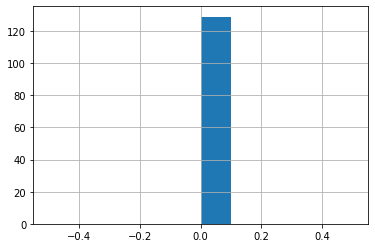

In [27]:
oversampled_data_df["Synonym (aus Polnischem)"].str.len().hist()

In [7]:
# annotators = ['T', 'A', 'P', 'B', 'K']
def get_class_data_by_annotator(annotator = 'all', class_name = 'Metapher', size= 0)-> pd.DataFrame:
  """
  Gets the class data by annotator
  :param annotator: the specific annotator to data from. If 'all', data from all annotators is returned
  :param class_name: The name of the class which should be returned
  :param size: The size of the returned dataframe. If size=0, all data is returned
  :return df: A dataframe of given size, containing all data of a given annotator and class
  """  
  annotators = set(raw_df['Annotator'].tolist())
  if annotator == 'all':
    df = raw_df.loc[(raw_df['Annotator'].isin(['T', 'A', 'P', 'B', 'K', 'GoldStandard', 'X']) ) & (raw_df['Metapher?'] == class_name)]
  elif annotator not in annotators:
    raise Exception('The given Annotator is not found')
  else:
    df = raw_df.loc[(raw_df['Annotator'] == annotator) & (raw_df['Metapher?'] == class_name)]

  # shuffle rows
  df = df.sample(frac=1).reset_index(drop=True)

  if size != 0:
    df = df.head(size)

  return df

In [8]:
def baseline(train_texts, test_texts, train_labels, test_labels, strategy="most_frequent"):
  """
  Returns the Accuracy, Average Macro F1 score and individual Macro F1 score for each class for a given set of train and test data with a given 
  :param train_texts: The train set
  :param test_texts: The test set
  :param train_labels: The train labels
  :param test_labels: The test labels
  :param strategy: The strategy for the classifier (for example 'most_frequent', 'stratified')
  :return acc: The accuracy of the baseline classifier on the given data with the given strategy
  :return macro_f1: The average Macro F1 score of the baseline classifier on the given data with the given strategy
  :return per_class_macro_f1: The individual class Macro F1 scores of the baseline classifier on the given data with the given strategy
  """  
  dummy_clf = DummyClassifier(strategy=strategy)
  dummy_clf.fit(train_texts, train_labels)
  prediction = dummy_clf.predict(test_texts)
  # calculate accuracy using sklearn's function
  test_labels = test_labels.to_numpy(dtype=int)
  prediction = prediction.astype(int)
  acc = accuracy_score(test_labels, prediction)
  macro_f1 = f1_score(test_labels, prediction, average='macro')
  per_class_macro_f1 = f1_score(test_labels, prediction, average=None).tolist()

  display("-----------------------------------")
  display("Baseline using strategy=", strategy)
  display("Accuracy:", acc)
  display("Macro F1:", macro_f1)
  display("Per Class Macro F1:", per_class_macro_f1)
  display("-----------------------------------")

  return acc, macro_f1, per_class_macro_f1

In [9]:
def load_model_tokenizer(model_type='redewiedergabe', smote=False):
  """
  Returns an individual model and corresponding tokenizer 
  :param model_type: The type of model to load
  :param smote: The test set
  :return model: The average Macro F1 score of the baseline classifier on the given data with the given strategy
  :return tokenizer: The individual class Macro F1 scores of the baseline classifier on the given data with the given strategy
  """    

  if model_type == 'fine_tuned':
    if smote>0:
      model = BertForSequenceClassificationSMOTE.from_pretrained(ROOT_PATH + MODEL_PATH, cache_dir=None, num_labels=3)
    else:
      model = BertForSequenceClassification.from_pretrained(ROOT_PATH + MODEL_PATH, cache_dir=None, num_labels=3)
    tokenizer = AutoTokenizer.from_pretrained(ROOT_PATH + MODEL_PATH)
  elif model_type == 'intermediate_task_vua':
    if smote>0:
      model = BertForSequenceClassificationSMOTE.from_pretrained(ROOT_PATH + '/intermediate-task-vua/model', num_labels=3, ignore_mismatched_sizes=True)
    else:
      model = BertForSequenceClassification.from_pretrained(ROOT_PATH + '/intermediate-task-vua/model', num_labels=3, ignore_mismatched_sizes=True)
    tokenizer = AutoTokenizer.from_pretrained(ROOT_PATH + '/intermediate-task-trofi-vua/model')
  elif model_type == 'intermediate_task_trofi':
    if smote>0:
      model = BertForSequenceClassificationSMOTE.from_pretrained(ROOT_PATH + '/intermediate-task-trofi/model', num_labels=3, ignore_mismatched_sizes=True)
    else:
      model = BertForSequenceClassification.from_pretrained(ROOT_PATH + '/intermediate-task-trofi/model', num_labels=3, ignore_mismatched_sizes=True)
    tokenizer = AutoTokenizer.from_pretrained(ROOT_PATH + '/intermediate-task-trofi/model')
  elif model_type == 'bert_base_multilingual_cased':
    if smote:
      model = BertForSequenceClassificationSMOTE.from_pretrained("bert-base-multilingual-cased", cache_dir=None, num_labels=3)
    else:
      model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", cache_dir=None, num_labels=3)
    tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')
  elif model_type == 'redewiedergabe':
    if smote:
      model = BertForSequenceClassificationSMOTE.from_pretrained("redewiedergabe/bert-base-historical-german-rw-cased", cache_dir=None, num_labels=3)
    else:
      model = BertForSequenceClassification.from_pretrained("redewiedergabe/bert-base-historical-german-rw-cased", cache_dir=None, num_labels=3)
    tokenizer = AutoTokenizer.from_pretrained("redewiedergabe/bert-base-historical-german-rw-cased")
  return model, tokenizer

In [10]:
class MetaphorDataset(torch.utils.data.Dataset):
    """
    The dataset class for metaphors
    """
    def __init__(self, encodings, labels):
        """
        Initializes the dataset
        :param encodings: The type of model to load
        :param labels: Boolean value to toggle SMOTE
        """    
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        """
        Returns an individual item by id
        :param idx: The id of the item to return
        :return item: The chosen item
        """    
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        """
        Helper to return the size of the dataset
        :return lenght: the size of the dataset
        """    
        return len(self.labels)

def compute_metrics(pred):
    """
    Computes accuracy, macro_f1 score and individual macro f1 per class for a given prediction
    :param pred: The prediction
    :return dict: A dictionary containing accuracy, macro_f1 score and individual macro f1 per class
    """    
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    # calculate accuracy using sklearn's function
    acc = accuracy_score(labels, preds)
    macro_f1 = f1_score(labels, preds, average='macro')
    per_class_macro_f1 = f1_score(labels, preds, average=None).tolist()
    return {
        'accuracy': acc,
        'macro_f1': macro_f1,
        'per_class_macro_f1': per_class_macro_f1,
    }


In [11]:
def save_results(path, results, annotator):
  """
  Saves the results of a training to a given path
  :param path: The path to save to
  :param results: The results to save
  :param annotator: The annotator of this particular result
  """    
  print("Saving results to", path)
  with open(path + '/results_'+annotator+'.csv', 'w') as csv_file:  
    writer = csv.writer(csv_file)
    for key, value in results.items():
       writer.writerow([key, value])

In [12]:
def get_numerical_labels(df):  
  """
  Returns the labels as numerical values: '0' for Non-Metaphors, '1' for Metaphor candidates and '2' for Metaphors
  :param df: The dataframe to change
  :return df: The changed dataframe, containing labels as numerical values
  """ 
  df.loc[df['Metapher?'] == 'Nein', 'Metapher?'] = 0
  df.loc[df['Metapher?'] == 'Metaphernkandidat', 'Metapher?'] = 1
  df.loc[df['Metapher?'] == 'Unklar', 'Metapher?'] = 1
  df.loc[df['Metapher?'] == 'Grenzfall', 'Metapher?'] = 1
  df.loc[df['Metapher?'] == 'Metapher', 'Metapher?'] = 2
  return df

In [13]:
def get_oversamples(entry):
  """
  Returns the oversampling entries corresponding to a specific entry
  :param entry: The entry to get the oversampling data to
  :return oversamples: The oversampling data to the given entry
  """ 
  oversamples = pd.DataFrame()
  textstelle = entry['Textstelle']
  # getting oversampling data from gold standard
  gold_standard_entry = get_numerical_labels(gold_standard_df[gold_standard_df['Textstelle']==textstelle])
  for language in ["Synonym (aus Englischem)", "Synonym (aus Spanischem)", "Synonym (aus Tchechischem)", "Synonym (aus Polnischem)"]:
    oversamples= oversamples.append(gold_standard_entry)
    oversamples.iloc[-1]['Textstelle'] = oversamples.iloc[-1][language]
  return oversamples

def generate_oversampled_data(df, size):
  """
  Generates oversampled data to given data with a specific size by randomly selecting from all oversampling data
  :param df: The data for which oversampling data should be generated
  :param size: The size of the generated data
  :return new_samples: The oversampling data to the given data with given size
  """   
  new_samples = pd.DataFrame()
  for index, row in df.iterrows():
    new_samples= new_samples.append(get_oversamples(row))
  return new_samples.sample(size)

In [14]:
def df_statistics(df):
    """
    Generates a statistic of a given dataframe
    :param df: The data for which a statistic should be generated
    :return statistic: The statistic of the given dataframe
    """   
    return "non-metaphors: {} ({:.0%}), metaphor candidates: {} ({:.0%}), metaphors: {} ({:.0%})".format(df['Metapher?'].value_counts()[0],df['Metapher?'].value_counts()[0]/df['Metapher?'].value_counts().sum(),df['Metapher?'].value_counts()[1],df['Metapher?'].value_counts()[1]/df['Metapher?'].value_counts().sum(),df['Metapher?'].value_counts()[2],df['Metapher?'].value_counts()[2]/df['Metapher?'].value_counts().sum())


In [15]:
# setting the maximum sentence length
max_length = 512
# setting the default stärkegrad of the raw data
raw_df = set_default_staerkegrad_df(raw_df)

def train(annotator, model_type, epochs=3, folds=10, oversampling=True, smote=0, path='/'):
  """
  Training a given model with k-fold cross-validation and various oversampling strategies
  The resulting metrics are saved as CSV to a given path
  :param annotator: The annotator on whose data to train
  :param model_type: The type of model to use
  :param epochs: The amount of epochs to train
  :param folds: The amount of folds to use for k-fold cross validation
  :param oversampling: Boolean to set true if oversampling should be used
  :param smote: K value for smote. If set to 0, smote is deactivated
  :param path: The path to save the results to
  :return evaluation_results: The results of the evaluation of the trained model
  """     
  print("Training with data from annotator", annotator)
  metaphor_candidates = get_class_data_by_annotator(annotator, class_name='Metaphernkandidat')
  metaphors = get_class_data_by_annotator(annotator, class_name='Metapher')
  # Using only the same amount of non-metaphors as metaphor candidates
  not_metaphors = get_class_data_by_annotator(class_name='Nein', size=len(metaphor_candidates))

  df = pd.concat([metaphors, metaphor_candidates, not_metaphors])
  # Shuffle the rows  
  df = df.sample(frac=1).reset_index(drop=True)

  # Data Statistics
  samples = len(metaphor_candidates)+len(metaphors)+len(not_metaphors)
  print("Number of individual classes in data:", df_statistics(df))

  # changing the labels to numerical values
  df = get_numerical_labels(df)

  baseline_accuracy = []
  baseline_macro_f1 = []
  baseline_per_class_macro_f1 = []

  evaluation_accuracy = []
  evaluation_macro_f1 = []
  evaluation_per_class_macro_f1 = []


  # K-Fold Cross Validation
  kf = StratifiedKFold(n_splits=folds, shuffle=False)
  i = 0
  for train_index, test_index in kf.split(df['Textstelle'], df['Metapher?'].to_list()):
    
    model, tokenizer = load_model_tokenizer(model_type=model_type, smote=smote)
    i += 1
    display("-----------------------------------")
    print("Annotator", annotator, "| Fold #", i)

    train_samples = df.iloc[train_index.tolist()]
    test_samples = df.iloc[test_index.tolist()]

    train_metaphors = train_samples[train_samples["Metapher?"] == 2]
    test_metaphors = test_samples[test_samples["Metapher?"] == 2]

    #print("Number of individual classes in train:", df_statistics(train_samples))
    #print("Number of individual classes in test:", df_statistics(test_samples))

    if oversampling:
      # add oversampled metaphors
      oversampled__train_samples = generate_oversampled_data(df=train_metaphors, size=(train_samples['Metapher?'].value_counts()[0]-train_samples['Metapher?'].value_counts()[2]))

      train_samples = pd.concat([train_samples, oversampled__train_samples]) 

    #print("Number of individual classes in train (after oversampling):", df_statistics(train_samples))
    #print("Number of individual classes in test (after oversampling):", df_statistics(test_samples))


    train_texts = train_samples['Textstelle']
    test_texts = test_samples['Textstelle']
    train_labels = train_samples['Metapher?']
    test_labels = test_samples['Metapher?']

    # Baseline
    b_acc, b_macro_f1, b_per_class_macro_f1 = baseline(train_texts, test_texts, train_labels, test_labels, strategy="stratified") # use 'most_frequent' 'stratified' or 'uniform'

    baseline_accuracy.append(b_acc)
    baseline_macro_f1.append(b_macro_f1)
    baseline_per_class_macro_f1.append(b_per_class_macro_f1)
    
    train_encodings = tokenizer(train_texts.to_list(), truncation=True, padding=True, max_length=max_length)
    test_encodings = tokenizer(test_texts.to_list(), truncation=True, padding=True, max_length=max_length)


    # convert our tokenized data into a torch Dataset
    train_dataset = MetaphorDataset(train_encodings, train_labels.tolist())
    test_dataset = MetaphorDataset(test_encodings, test_labels.tolist())

    #if smote>0:
    #  get_smote_points(model, train_samples['Metapher?'].value_counts()[2], train_dataset, test_dataset)
    #  model.smote_factor = int(train_samples['Metapher?'].value_counts()[0]/train_samples['Metapher?'].value_counts()[2])-1
    #  model.smote_k = smote

    training_args = TrainingArguments(
        output_dir='./results',          # output directory
        num_train_epochs=epochs,              # total number of training epochs
        per_device_train_batch_size=8,  # batch size per device during training
        per_device_eval_batch_size=20,   # batch size for evaluation
        warmup_steps=500,                # number of warmup steps for learning rate scheduler
        weight_decay=0.01,               # strength of weight decay
        logging_dir='./logs',            # directory for storing logs
        load_best_model_at_end=True,     # load the best model when finished training (default metric is loss)
        # but you can specify `metric_for_best_model` argument to change to accuracy or other metric
        save_total_limit=1,
        save_strategy="epoch",
        logging_strategy="epoch",
        evaluation_strategy="epoch",     # evaluate each `logging_steps`
        metric_for_best_model="macro_f1",
    )

    trainer = Trainer(
        model=model,                         # the instantiated Transformers model to be trained
        args=training_args,                  # training arguments, defined above
        train_dataset=train_dataset,         # training dataset
        eval_dataset=test_dataset,          # evaluation dataset
        compute_metrics=compute_metrics,     # the callback that computes metrics of interest
    )

    trainer.train()
    #print("SMOTE created", model.smote_counter, "synthetic data points")

    evaluation = trainer.evaluate()

    evaluation_accuracy.append(evaluation['eval_accuracy'])
    evaluation_macro_f1.append(evaluation['eval_macro_f1'])
    evaluation_per_class_macro_f1.append(evaluation['eval_per_class_macro_f1'])
  
  evaluation_results = {
    "baseline_accuracy": baseline_accuracy,
    "baseline_macro_f1": baseline_macro_f1,
    "baseline_per_class_macro_f1": baseline_per_class_macro_f1,
    "evaluation_accuracy": evaluation_accuracy,
    "evaluation_macro_f1": evaluation_macro_f1,
    "evaluation_per_class_macro_f1": evaluation_per_class_macro_f1
  }

  try:
    save_results(path,evaluation_results, annotator)
  except:
    print("There seems to be a problem with Google Drive. The CSV could not be saved. Results are only stored locally in results[annotator].")
  return evaluation_results

In [16]:
#########################
# Parameters for Training
ANNOTATORS = [
    #'T',
    #'A',
    #'P',
    #'B', 
    #'K',
    'GoldStandard'] # specify the annotators on which to train. Possible annotators = ['T', 'A', 'P', 'B', 'K', 'GoldStandard']
EPOCHS=3
FOLDS=10
OVERSAMPLING = True
SMOTE = 0 #This defines the factor k for k-nearest-neighbors used by SMOTE. SMOTE is off if set to 0.
COMMENT='Unbalanced for all annotators.'
#########################
transformers.logging.set_verbosity_error()

current_results = {}
SAVE_RESULTS = True
foldernames = [] 

models = ['redewiedergabe'] # possible model_types are 'redewiedergabe', 'bert_base_multilingual_cased', 'fine_tuned', 'intermediate_task_trofi' and 'intermediate_task_vua'
for model in models: 
  folder_name = datetime.today().strftime('%Y-%m-%d-%H:%M:%S') + " | " + model + " | EPOCHS "+ str(EPOCHS)+ " | FOLDS "+ str(FOLDS)+ ((" | SMOTE (K="+str(SMOTE)+")") if SMOTE>0 else "") + ((" | OVERSAMPLING") if OVERSAMPLING>0 else "")
  RUN_PATH = ROOT_PATH + RESULTS_PATH + '/runs/' + folder_name
  print(RUN_PATH)

  if SAVE_RESULTS:
    print(RUN_PATH)
    !mkdir "$RUN_PATH"
    save_settings(RUN_PATH, ANNOTATORS, EPOCHS, FOLDS, model, OVERSAMPLING, SMOTE, COMMENT)
    foldernames.append(folder_name)

  for annotator in ANNOTATORS: 
    result = train(annotator, model, epochs=EPOCHS, folds=FOLDS, oversampling=OVERSAMPLING, smote=SMOTE, path=RUN_PATH) 
    current_results[annotator] = result
    foldernames.append(folder_name)

/Users/fynn/Uni/DL4NLP/results/runs/2022-07-29-10:15:49 | redewiedergabe | EPOCHS 3 | FOLDS 10 | OVERSAMPLING
/Users/fynn/Uni/DL4NLP/results/runs/2022-07-29-10:15:49 | redewiedergabe | EPOCHS 3 | FOLDS 10 | OVERSAMPLING
Settings saved to /Users/fynn/Uni/DL4NLP/results/runs/2022-07-29-10:15:49 | redewiedergabe | EPOCHS 3 | FOLDS 10 | OVERSAMPLING
Training with data from annotator GoldStandard
Number of individual classes in data: non-metaphors: 529 (45%), metaphor candidates: 529 (45%), metaphors: 129 (11%)


'-----------------------------------'

Annotator GoldStandard | Fold # 1


/var/folders/j4/qmf6qmvd1gv0nctgx3m6jm3r0000gn/T/ipykernel_26536/3459997705.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  oversamples= oversamples.append(gold_standard_entry)


KeyError: 'Synonym (aus Englischem)'

In [ ]:
model

In [ ]:
def open_csv(path):
  """
  Loads all CSV data for plotting
  :param path: The path to load from
  :return df: The loaded data as a dataframe
  """
  df = pd.read_csv(path, names=['measure', 'results'], header=None)
  annotator = path[-5]
  
  df['results'] = df['results'].apply(lambda x: np.array(json.loads(x)))
  df['annotator'] = annotator
  return df

# Plotting with multiple annotators
def open_csv_annotators(path, annotator):
  """
  Loads all CSV data for plotting for individual annotators
  :param path: The path to load from
  :return df: The loaded data as a dataframe
  """
  print(path)
  try:
    df = pd.read_csv(path, names=['measure', 'results'], header=None)
    df['results'] = df['results'].apply(lambda x: np.fromstring(x[1:-1], sep=', '))
    df['annotator'] = annotator
    annotator_names.append(annotator)
  except:
    df = pd.DataFrame()
  return df

We can see that the Bert Model is unable to identify metaphors if it is not trained on backtranslations.